In [1]:
import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

In [2]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

In [3]:
pl.seed_everything(42)

Global seed set to 42


42

In [4]:
df = pd.read_csv("news_summary.csv", encoding='latin-1')
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [5]:
df = df[['text', 'ctext']]
df.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
df.columns = ['summary', 'text']
df = df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [7]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df.shape, test_df.shape

((3956, 2), (440, 2))

In [8]:
class NewsSummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        text = data_row['text']

        text_encoding = tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        summary_encoding = tokenizer(
            data_row['summary'],
            max_length=self.summary_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100 # to make sure we have correct labels for T5 text generation

        return dict(
            text=text,
            summary=data_row['summary'],
            text_input_ids=text_encoding['input_ids'].flatten(),
            text_attention_mask=text_encoding['attention_mask'].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding['attention_mask'].flatten()
        )

In [9]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 8,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128
    ):
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def setup(self, stage=None):
        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

In [10]:
MODEL_NAME = 't5-base'

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [11]:
text_token_counts, summary_token_counts = [], []

for _, row in train_df.iterrows():
    text_token_count = len(tokenizer.encode(row['text']))
    text_token_counts.append(text_token_count)

    summary_token_count = len(tokenizer.encode(row['summary']))
    summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:ylabel='Count'>

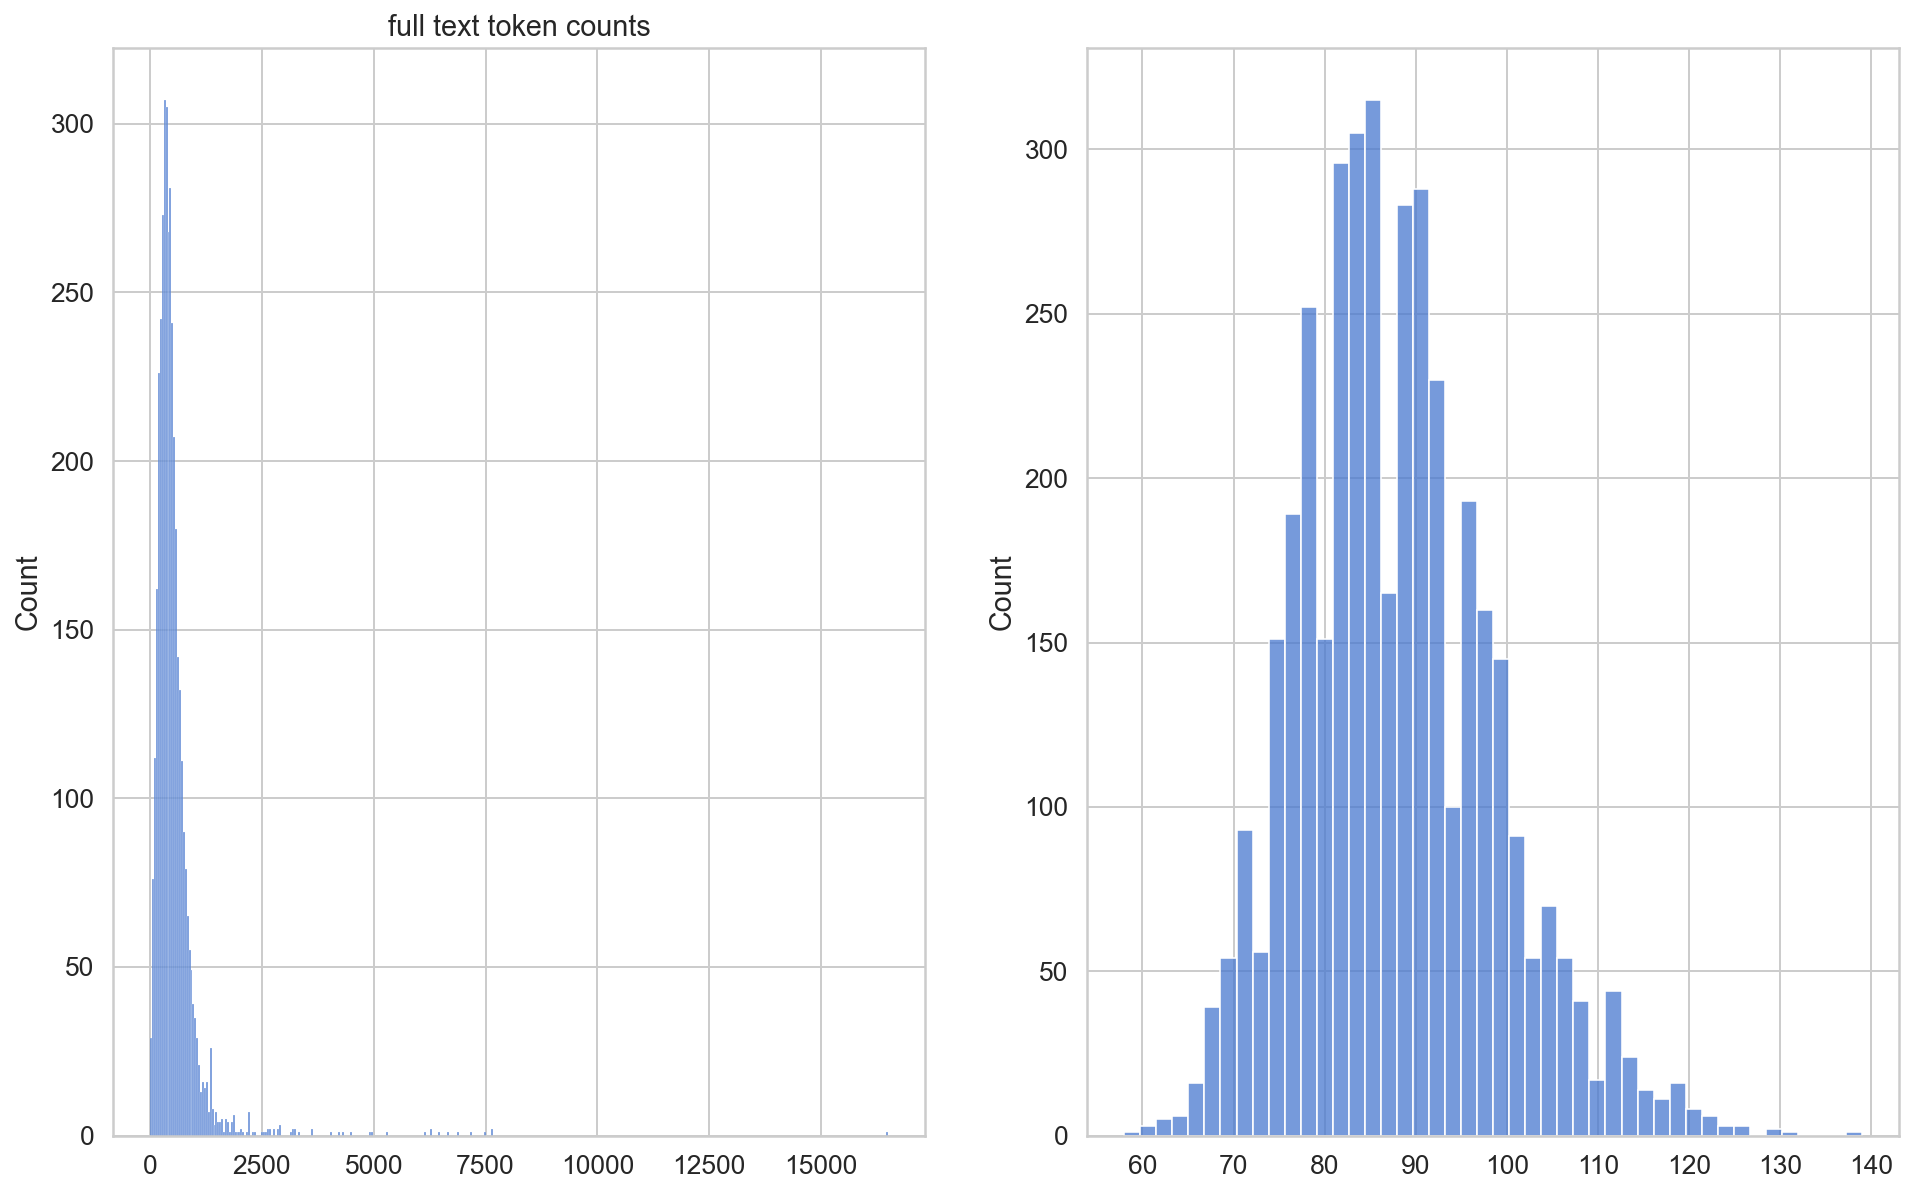

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(text_token_counts, ax=ax1)
ax1.set_title('full text token counts')
sns.histplot(summary_token_counts, ax=ax2)

In [13]:
N_EPOCHS = 3
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_df, test_df, tokenizer)

In [14]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
    
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [15]:
model = NewsSummaryModel()

In [28]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs
%tensorboard dev upload --logdir \ './lightning_logs'
#taskkill /im tensorboard.exe /f
#del /q %TMP%\.tensorboard-info\*

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2022-02-24 09:51:34.446189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-02-24 09:51:34.446334: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

 ./lightning_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`

In [29]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name='news-summary')

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

MisconfigurationException: You requested GPUs: [0]
 But your machine only has: []